Import modules

In [10]:
import warnings
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import decode_predictions
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [11]:
warnings.simplefilter("ignore", category=DeprecationWarning)

# DATA PREPARATION

Create Dataframe for train labels.

In [12]:
train_labels = '/Users/asifbala/Desktop/humpback-whale-identification.zip Folder/train.csv'
train_df = pd.read_csv(train_labels)

In [13]:
print(train_df.shape)

(25361, 2)


In [14]:
print(train_df.head())

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale


In [15]:
print(train_df.describe())

                Image         Id
count           25361      25361
unique          25361       5005
top     405410b2e.jpg  new_whale
freq                1       9664


In [16]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25361 entries, 0 to 25360
Data columns (total 2 columns):
Image    25361 non-null object
Id       25361 non-null object
dtypes: object(2)
memory usage: 396.3+ KB
None


In [17]:
print(train_df['Id'].value_counts().head(20))

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
w_700ebb4      57
w_3de579a      54
w_564a34b      51
w_fd3e556      50
w_88e4537      49
w_2b069ba      48
w_d405854      47
w_f0fe284      45
w_789c969      45
w_343f088      40
w_5e8e218      40
w_778e474      40
w_60ce6fc      37
w_a9304b9      37
w_5a2634c      37
Name: Id, dtype: int64


In [18]:
class_with_count_1 = train_df['Id'].value_counts() == 1
print(class_with_count_1.value_counts())

False    2932
True     2073
Name: Id, dtype: int64


There are 25361 samples/images belonging 5005 classes/Ids.'New whale' class has the most samples belonging to the class at 9664, far outnumbering all the other classes.

Reduce sample size due to computational restrictions. Computer unable to train more samples with extremely long wait times and/or crashing.

In [19]:
train_df = train_df[:6300]

In [20]:
print(train_df.shape)

(6300, 2)


In [21]:
print(train_df.head())

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale


In [22]:
print(train_df.describe())

                Image         Id
count            6300       6300
unique           6300       2282
top     275f6af9a.jpg  new_whale
freq                1       2448


In [23]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 2 columns):
Image    6300 non-null object
Id       6300 non-null object
dtypes: object(2)
memory usage: 98.5+ KB
None


In [24]:
print(train_df['Id'].value_counts().head(20))

new_whale    2448
w_23a388d      19
w_9c506f6      16
w_9b5109b      14
w_88e4537      13
w_0369a5c      13
w_778e474      13
w_700ebb4      12
w_a9304b9      11
w_fd3e556      10
w_1ca9ab1      10
w_3de579a      10
w_b9e5911      10
w_2b069ba      10
w_5a2634c      10
w_488865e      10
w_d405854      10
w_4bf625b      10
w_789c969       9
w_5773c71       9
Name: Id, dtype: int64


In [25]:
class_with_count_1 = train_df['Id'].value_counts() == 1
print(class_with_count_1.value_counts())

True     1544
False     738
Name: Id, dtype: int64


With the 6300 samples being used, they belong to 2282 classes/Ids.'New whale' class has the most samples belonging to any class with 2448, far outnumbering all the other classes.

# IMAGE AUGMENTATION

Method for Preparing Images to be input into convolutional neural network.

In [6]:
def image_prep(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, 224, 224, 3))
    count = 0    
    for fig in data['Image']:
        img = image.load_img("/Users/asifbala/Desktop/humpback-whale-identification.zip Folder/"+dataset+"/"+fig, target_size=(224, 224, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_train[count] = x
        if (count%5000 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1    
    return X_train

Method for Preparing Labels to be input into convolutional neural network.

In [7]:
def label_prep(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    return y

Prepare images to be input into convolutional neural network.

In [8]:
X = image_prep(train_df, train_df.shape[0], "train")

X /= 255

print(X.shape)

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  5001 ,  3347515d9.jpg
(6300, 224, 224, 3)


Prepare labels to be input into convolutional neural network.

In [9]:
y = label_prep(train_df['Id'])

y_labels = np.argmax(y,axis=1)

print(y_labels.shape)

/Users/asifbala/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(6300,)


Method to plot whale images along with the label classification number.

In [10]:
def plot_images(images, cls_true):
    assert len(images) == len(cls_true)     
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        xlabel = "{}".format(cls_true[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

Sample of whale images along with the label classification number.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


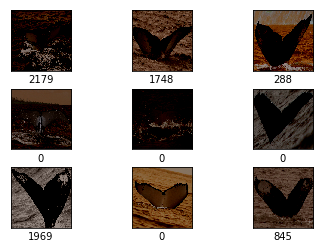

In [11]:
plot_images(X[:9],y_labels[:9])

# TRANSFER LEARNING

Transfer learning with VGG16 summary.

In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(y.shape[1], activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = False

model = Model(input=base_model.input, output=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/Users/asifbala/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


Results with limited sample size of 6300. Model overfit after the second epoch (val loss increasing) due to lack of samples that computer could work with. 

In [ ]:
history = model.fit(X, y,epochs=5,batch_size=256,validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 5040 samples, validate on 1260 samples
Epoch 1/5


Could not run neural network on Jupyter notebook without Kernel dying. Ran on Spyder IDE copied here.

Epoch 1/5
5040/5040 [==============================] - 8362s 2s/step - loss: 5.8428 - acc: 0.3706 - val_loss: 5.6079 - val_acc: 0.3889

Epoch 2/5
5040/5040 [==============================] - 8292s 2s/step - loss: 5.3108 - acc: 0.3885 - val_loss: 5.4997 - val_acc: 0.3889

Epoch 3/5
5040/5040 [==============================] - 8022s 2s/step - loss: 5.1524 - acc: 0.3885 - val_loss: 5.5504 - val_acc: 0.3889

Epoch 4/5
5040/5040 [==============================] - 7994s 2s/step - loss: 5.0337 - acc: 0.3885 - val_loss: 5.6056 - val_acc: 0.3889

Epoch 5/5
5040/5040 [==============================] - 7963s 2s/step - loss: 4.9292 - acc: 0.3885 - val_loss: 5.6571 - val_acc: 0.3889


Lowest validation loss for this model occurred at second epoch of 5.4997. This is slightly higher than the validation loss of 5.4830 from the scratch model which proves it did not learn as well.